In [1]:
from google.colab import files
uploaded = files.upload()

Saving sesshu.jpg to sesshu.jpg


In [14]:
from google.colab import files
uploaded = files.upload()

Saving kamataki.jpg to kamataki.jpg


In [3]:
import keras

Using TensorFlow backend.


In [0]:
from keras.preprocessing.image import load_img, img_to_array

# ターゲットファイルのイメージ
target_image_path = 'ootaki.jpg'
# リファレンス画像のイメージ
style_reference_image_path = 'sesshu.jpg'

# 生成する画像の寸法
width, height = load_img(target_image_path).size
img_height = 400
img_width = int(width * img_height / height)

In [0]:
import numpy as np
from keras.applications import vgg19

def preprocess_image(image_path):
    img = load_img(image_path, target_size=(img_height, img_width))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = vgg19.preprocess_input(img)
    return img

def deprocess_image(x):
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    # 'BGR'->'RGB'
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [6]:
from keras import backend as K

target_image = K.constant(preprocess_image(target_image_path))
style_reference_image = K.constant(preprocess_image(style_reference_image_path))

# 生成する画像を保存する
combination_image = K.placeholder((1, img_height, img_width, 3))

# 3つの画像を１つのバッチに纏める
input_tensor = K.concatenate([target_image,
                              style_reference_image,
                              combination_image], axis=0)

# ImagenetをVGG19で学習した際の重みの利用
model = vgg19.VGG19(input_tensor=input_tensor,
                    weights='imagenet',
                    include_top=False)
print('Model loaded.')

80142336/80134624 [==============================] - 1s 0us/step
Model loaded.


In [0]:
def content_loss(base, combination):
    return K.sum(K.square(combination - base))

In [0]:
def gram_matrix(x):
    features = K.batch_flatten(K.permute_dimensions(x, (2, 0, 1)))
    gram = K.dot(features, K.transpose(features))
    return gram


def style_loss(style, combination):
    S = gram_matrix(style)
    C = gram_matrix(combination)
    channels = 3
    size = img_height * img_width
    return K.sum(K.square(S - C)) / (4. * (channels ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    a = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, 1:, :img_width - 1, :])
    b = K.square(
        x[:, :img_height - 1, :img_width - 1, :] - x[:, :img_height - 1, 1:, :])
    return K.sum(K.pow(a + b, 1.25))

In [10]:
outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])

content_layer = 'block5_conv2'

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1',
                'block4_conv1',
                'block5_conv1']

total_variation_weight = 1e-4
style_weight = 1.
content_weight = 0.025

In [0]:
# 損失関数の定義
loss = K.variable(0.)
layer_features = outputs_dict[content_layer]
target_image_features = layer_features[0, :, :, :]
combination_features = layer_features[2, :, :, :]
loss += content_weight * content_loss(target_image_features,
                                      combination_features)
for layer_name in style_layers:
    layer_features = outputs_dict[layer_name]
    style_reference_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    sl = style_loss(style_reference_features, combination_features)
    loss += (style_weight / len(style_layers)) * sl
loss += total_variation_weight * total_variation_loss(combination_image)

In [0]:
# 勾配の計算
grads = K.gradients(loss, combination_image)[0]

# 現在の損失と現在の勾配の値を取得する
fetch_loss_and_grads = K.function([combination_image], [loss, grads])

In [0]:
class Evaluator(object):

    def __init__(self):
        self.loss_value = None
        self.grads_values = None

    def loss(self, x):
        assert self.loss_value is None
        x = x.reshape((1, img_height, img_width, 3))
        outs = fetch_loss_and_grads([x])
        loss_value = outs[0]
        grad_values = outs[1].flatten().astype('float64')
        self.loss_value = loss_value
        self.grad_values = grad_values
        return self.loss_value

    def grads(self, x):
        assert self.loss_value is not None
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values

evaluator = Evaluator()

In [12]:
from scipy.optimize import fmin_l_bfgs_b
from scipy.misc import imsave
import time

result_prefix = 'style_transfer_result'
iterations = 20

x = preprocess_image(target_image_path)
x = x.flatten()
for i in range(iterations):
    print('Start of iteration', i)
    start_time = time.time()
    x, min_val, info = fmin_l_bfgs_b(evaluator.loss, x,
                                     fprime=evaluator.grads, maxfun=20)
    print('Current loss value:', min_val)
    # 現在生成されている画像の保存
    img = x.copy().reshape((img_height, img_width, 3))
    img = deprocess_image(img)
    fname = result_prefix + '_at_iteration_%d.png' % i
    imsave(fname, img)
    end_time = time.time()
    print('Image saved as', fname)
    print('Iteration %d completed in %ds' % (i, end_time - start_time))

Start of iteration 0
Current loss value: 1156054400.0
Image saved as style_transfer_result_at_iteration_0.png
Iteration 0 completed in 19s
Start of iteration 1
Current loss value: 435229600.0
Image saved as style_transfer_result_at_iteration_1.png
Iteration 1 completed in 14s
Start of iteration 2
Current loss value: 244261580.0
Image saved as style_transfer_result_at_iteration_2.png
Iteration 2 completed in 14s
Start of iteration 3
Current loss value: 173224300.0
Image saved as style_transfer_result_at_iteration_3.png
Iteration 3 completed in 14s
Start of iteration 4
Current loss value: 131674670.0
Image saved as style_transfer_result_at_iteration_4.png
Iteration 4 completed in 14s
Start of iteration 5
Current loss value: 107943160.0
Image saved as style_transfer_result_at_iteration_5.png
Iteration 5 completed in 14s
Start of iteration 6
Current loss value: 93775170.0
Image saved as style_transfer_result_at_iteration_6.png
Iteration 6 completed in 14s
Start of iteration 7
Current loss 

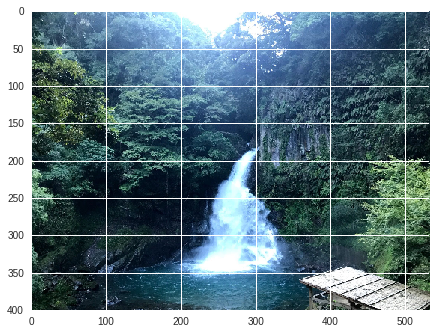

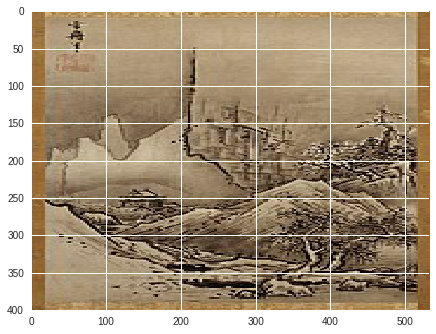

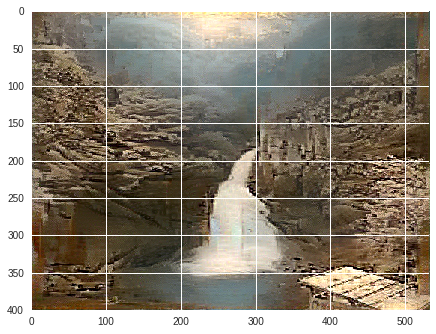

In [13]:
from matplotlib import pyplot as plt

# Content image
plt.imshow(load_img(target_image_path, target_size=(img_height, img_width)))
plt.figure()

# Style image
plt.imshow(load_img(style_reference_image_path, target_size=(img_height, img_width)))
plt.figure()

# Generate image
plt.imshow(img)
plt.show()